In [1]:
import numpy as np
import torch
import torch.nn as nn
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import random


In [2]:
# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# ================= DATA LOADING =================
X_all = np.load("X_train_all.npy")  # (22400, 180) input sinyal
y_all = np.load("y_train_all.npy")  # (22400,) labels

# Pastikan data dalam format yang benar
X_all = X_all.astype("float32")
y_all = y_all.astype("int64")

# Add channel dimension if necessary
if X_all.ndim == 2:
    X_all = np.expand_dims(X_all, axis=2)

# Normalize the data if necessary
if X_all.max() > 1.0:
    X_all = X_all / 255.0

X_tensor = torch.from_numpy(X_all)
y_tensor = torch.from_numpy(y_all)
num_classes = int(np.unique(y_all).size)

print(f"Data shape: {X_tensor.shape}")
print(f"Number of classes: {num_classes}")


Data shape: torch.Size([22400, 180, 1])
Number of classes: 4


In [6]:
# ================= MODEL: Transformer Encoder-Decoder =================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerEncoderDecoder(nn.Module):
    def __init__(self, input_dim=1, d_model=128, nhead=4, num_encoder_layers=3,
                 num_decoder_layers=2, dim_feedforward=256, dropout=0.1, num_classes=5, max_len=200):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, 
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Learned BOS token for decoder start
        self.bos_token = nn.Parameter(torch.randn(1, 1, d_model))

        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        B, L, C = x.shape
        x = self.input_proj(x)
        x = self.pos_enc(x)

        # Encoder output
        memory = self.encoder(x)

        # Create the target for the decoder (BOS token as input)
        tgt = self.bos_token.expand(B, 1, -1)
        
        # Pass to the decoder
        out = self.decoder(tgt=tgt, memory=memory)

        # Squeeze output for final prediction
        out = out.squeeze(1)
        out = self.norm(out)

        logits = self.head(out)
        return logits


In [7]:
# ================= OPTIMAL HYPERPARAMETER CONFIGURATION =================
# Based on your successful run, using the best performing configuration
OPTIMAL_CONFIG = {
    'd_model': 128, 
    'nhead': 4, 
    'num_encoder_layers': 3, 
    'num_decoder_layers': 2, 
    'dim_feedforward': 256, 
    'dropout': 0.1, 
    'lr': 1e-3, 
    'batch_size': 64
}

# ================= TRAINING FUNCTIONS =================
def run_epoch(model, loader, criterion, optimizer=None, device="cpu"):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []
    
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        if xb.ndim == 2:
            xb = xb.unsqueeze(2)

        if train_mode:
            optimizer.zero_grad()

        logits = model(xb)
        loss = criterion(logits, yb)

        if train_mode:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        correct += (logits.argmax(1) == yb).sum().item()
        total += yb.size(0)

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds)

    avg_loss = total_loss / len(loader)
    avg_acc = correct / total
    return avg_loss, avg_acc, y_true, y_pred

In [11]:
def train_with_optimal_config(save_dir="checkpoints_transformer_tuned"):
    print(f"\nTraining Transformer with Optimal Configuration...")
    print("=" * 60)
    print("Configuration:")
    for key, value in OPTIMAL_CONFIG.items():
        print(f"  {key}: {value}")
    print("=" * 60)
    
    os.makedirs(save_dir, exist_ok=True)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    per_class_metrics = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_tensor, y_tensor), 1):
        print(f"\n========== Fold {fold}/5 ==========")
        X_tr, y_tr = X_tensor[train_idx], y_tensor[train_idx]
        X_va, y_va = X_tensor[val_idx], y_tensor[val_idx]

        train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=OPTIMAL_CONFIG['batch_size'], shuffle=True)
        val_loader = DataLoader(TensorDataset(X_va, y_va), batch_size=OPTIMAL_CONFIG['batch_size'], shuffle=False)

        model = TransformerEncoderDecoder(
            d_model=OPTIMAL_CONFIG['d_model'],
            nhead=OPTIMAL_CONFIG['nhead'],
            num_encoder_layers=OPTIMAL_CONFIG['num_encoder_layers'],
            num_decoder_layers=OPTIMAL_CONFIG['num_decoder_layers'],
            dim_feedforward=OPTIMAL_CONFIG['dim_feedforward'],
            dropout=OPTIMAL_CONFIG['dropout'],
            num_classes=num_classes
        ).to(device)

        # Class weights for imbalanced dataset
        class_weights = compute_class_weight('balanced', classes=np.unique(y_tr.numpy()), y=y_tr.numpy())
        class_weights = torch.FloatTensor(class_weights).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.AdamW(model.parameters(), lr=OPTIMAL_CONFIG['lr'], weight_decay=1e-4)

        best_val_acc = -1.0
        best_state = None
        
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        # Training loop - 20 epochs
        for epoch in range(1, 21):
            tr_loss, tr_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, y_true_ep, y_pred_ep = run_epoch(model, val_loader, criterion, None, device)

            train_losses.append(tr_loss)
            val_losses.append(val_loss)
            train_accuracies.append(tr_acc)
            val_accuracies.append(val_acc)

            print(f"Epoch {epoch:02d}/20 | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = model.state_dict().copy()

        # Save best model
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), os.path.join(save_dir, f"transformer_tuned_fold{fold}.pth"))
        print(f"✅ Model saved: transformer_tuned_fold{fold}.pth")

        # Final evaluation
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for imgs, labels_b in val_loader:
                imgs = imgs.to(device)
                if imgs.ndim == 2:
                    imgs = imgs.unsqueeze(2)
                logits = model(imgs)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                y_pred.extend(preds)
                y_true.extend(labels_b.numpy())

        # Metrics calculation
        report = classification_report(y_true, y_pred, output_dict=True, target_names=["N", "S", "V", "Q"], zero_division=0)
        
        # Confusion Matrix and specificity
        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
        cm_sum = cm.sum()
        TP = np.diag(cm)
        FP = cm.sum(axis=0) - TP
        FN = cm.sum(axis=1) - TP
        TN = cm_sum - (TP + FP + FN)
        specificity_per_class = TN / (TN + FP + 1e-8)

        # Save per-class metrics
        for i, cname in enumerate(["N", "S", "V", "Q"]):
            per_class_metrics.append({
                "Fold": f"Fold {fold}",
                "Class": cname,
                "Precision": report[cname]["precision"],
                "Sensitivity": report[cname]["recall"],
                "Specificity": specificity_per_class[i],
                "F1-Score": report[cname]["f1-score"]
            })

        # Fold summary metrics
        fold_summary = {
            "Fold": fold,
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
            "Sensitivity": recall_score(y_true, y_pred, average="weighted", zero_division=0),
            "Specificity": specificity_per_class.mean(),
            "F1-Score": f1_score(y_true, y_pred, average="weighted", zero_division=0)
        }
        fold_metrics.append(fold_summary)

        # ----------------- Save visuals (per fold) -----------------
        # Confusion Matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["N", "S", "V", "Q"])
        fig, ax = plt.subplots(figsize=(5.5, 5))
        disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
        plt.title(f"Confusion Matrix - Fold {fold}")
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"transformer_confusion_matrix_fold{fold}.png"))
        plt.close(fig)

        # Accuracy curve
        plt.figure()
        plt.plot(train_accuracies, label="Train Accuracy")
        plt.plot(val_accuracies, label="Validation Accuracy")
        plt.title(f"Accuracy - Fold {fold}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"transformer_accuracy_fold{fold}.png"))
        plt.close()

        # Loss curve
        plt.figure()
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.title(f"Loss - Fold {fold}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"transformer_loss_fold{fold}.png"))
        plt.close()

        # Clean up GPU memory
        del model, optimizer, train_loader, val_loader
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # ================= SIMPAN TABEL RINGKASAN =================
    df_folds = pd.DataFrame(fold_metrics)
    df_folds.to_csv(os.path.join(save_dir, "fold_summary_metrics.csv"), index=False)

    # ================= SIMPAN TABEL PER KELAS =================
    df_per_class = pd.DataFrame(per_class_metrics)
    df_per_class.to_csv(os.path.join(save_dir, "per_class_metrics.csv"), index=False)

    # ---------------------------
    # Hitung Rata-rata Metrik per Fold
    # ---------------------------
    df_fold = pd.DataFrame(fold_metrics)

    # Menghitung rata-rata dari metrik yang diinginkan per fold
    avg_metrics = df_fold[["Accuracy", "Precision", "Sensitivity", "Specificity", "F1-Score"]].mean(numeric_only=True)

    # Menambahkan baris 'Average' ke DataFrame
    avg_row = {"Fold": "Average"}
    avg_row.update({k: float(v) for k, v in avg_metrics.to_dict().items()})
    df_fold = pd.concat([df_fold, pd.DataFrame([avg_row])], ignore_index=True)

    # Menyimpan hasil summary fold dan rata-rata
    df_fold.to_csv(os.path.join(save_dir, "fold_summary_metrics_with_average.csv"), index=False)

    # ---------------------------
    # Simpan Tabel Metrik Per Kelas
    # ---------------------------
    df_per_class = pd.DataFrame(per_class_metrics)
    df_per_class.to_csv(os.path.join(save_dir, "per_class_metrics.csv"), index=False)

    print(f"\n✅ Semua model, grafik, dan metrik Transformer Tuned disimpan di folder: {save_dir}")
    
    return df_fold, df_per_class

# Direct execution
print("🚀 Transformer Encoder-Decoder dengan Optimal Configuration")
print("=" * 60)

fold_results, per_class_results = train_with_optimal_config()

print("\n✅ TRAINING COMPLETED!")
print("Check the 'checkpoints_transformer_tuned' folder for results.")

🚀 Transformer Encoder-Decoder dengan Optimal Configuration

Training Transformer with Optimal Configuration...
Configuration:
  d_model: 128
  nhead: 4
  num_encoder_layers: 3
  num_decoder_layers: 2
  dim_feedforward: 256
  dropout: 0.1
  lr: 0.001
  batch_size: 64

========== Fold 1/5 ==========
Epoch 01/20 | Train Loss: 0.5468 Acc: 0.7837 | Val Loss: 0.3320 Acc: 0.8904
Epoch 02/20 | Train Loss: 0.2578 Acc: 0.9155 | Val Loss: 0.2065 Acc: 0.9357
Epoch 03/20 | Train Loss: 0.2141 Acc: 0.9291 | Val Loss: 0.1820 Acc: 0.9437
Epoch 04/20 | Train Loss: 0.1960 Acc: 0.9360 | Val Loss: 0.1725 Acc: 0.9429
Epoch 05/20 | Train Loss: 0.1783 Acc: 0.9410 | Val Loss: 0.1758 Acc: 0.9435
Epoch 06/20 | Train Loss: 0.2006 Acc: 0.9339 | Val Loss: 0.1635 Acc: 0.9480
Epoch 07/20 | Train Loss: 0.1565 Acc: 0.9478 | Val Loss: 0.1533 Acc: 0.9533
Epoch 08/20 | Train Loss: 0.1595 Acc: 0.9463 | Val Loss: 0.1651 Acc: 0.9408
Epoch 09/20 | Train Loss: 0.1520 Acc: 0.9485 | Val Loss: 0.2371 Acc: 0.9400
Epoch 10/20 | Tra

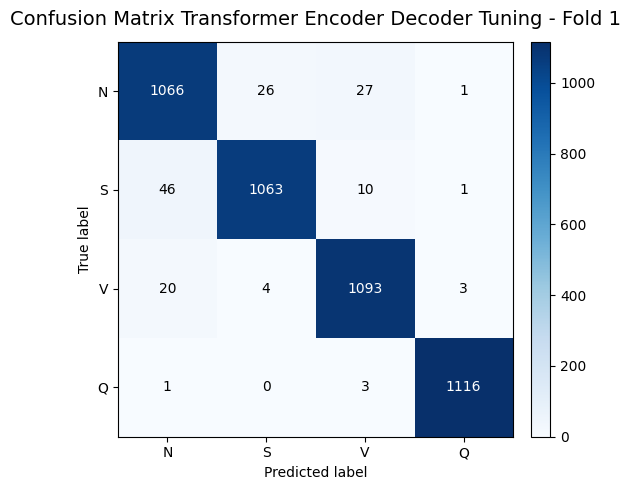

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Folder simpan ===
save_dir = "checkpoints_transformer_tuned"
os.makedirs(save_dir, exist_ok=True)

# Confusion matrix (Fold 1)
cm = np.array([
    [1066,  26,  27,   1],  # True N
    [  46, 1063, 10,   1],  # True S
    [  20,   4, 1093,  3],  # True V
    [   1,   0,   3, 1116]  # True Q
], dtype=int)

classes = ['N', 'S', 'V', 'Q']

# Plot sederhana tanpa grid
fig, ax = plt.subplots(figsize=(5.5, 5))
im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

ax.set_title('Confusion Matrix Transformer Encoder Decoder Tuning - Fold 1', pad=12, fontsize=14)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Colorbar
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Anotasi nilai di tiap sel
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}',
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=10)

plt.tight_layout()

# Simpan ke folder checkpoints_transformer_encoder_decoder
out_path = os.path.join(save_dir, 'confusion_matrix_fold1.png')
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()


In [7]:
def evaluate_config(config, X_tensor, y_tensor, num_epochs=25):
    """Evaluate a hyperparameter configuration using 5-fold CV"""
    print(f"\n🔍 Evaluating config: {config}")
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_tensor, y_tensor), 1):
        print(f"  Fold {fold}/5...")
        
        X_tr, y_tr = X_tensor[train_idx], y_tensor[train_idx]
        X_va, y_va = X_tensor[val_idx], y_tensor[val_idx]

        train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(TensorDataset(X_va, y_va), batch_size=config['batch_size'], shuffle=False)

        model = TransformerEncoderDecoder(
            d_model=config['d_model'],
            nhead=config['nhead'],
            num_encoder_layers=config['num_encoder_layers'],
            num_decoder_layers=config['num_decoder_layers'],
            dim_feedforward=config['dim_feedforward'],
            dropout=config['dropout'],
            num_classes=num_classes
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)

        best_val_acc = 0.0
        patience = 0
        max_patience = 5

        for epoch in range(num_epochs):
            tr_loss, tr_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, _, _ = run_epoch(model, val_loader, criterion, None, device)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience = 0
            else:
                patience += 1
                if patience >= max_patience:
                    break

        fold_scores.append(best_val_acc)
        print(f"    Best Val Acc: {best_val_acc:.4f}")
        
        # Clean up
        del model, optimizer
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    print(f"  📊 Mean Score: {mean_score:.4f} ± {std_score:.4f}")
    
    return {
        'config': config,
        'mean_score': mean_score,
        'std_score': std_score,
        'fold_scores': fold_scores
    }

In [8]:
# ================= HYPERPARAMETER TUNING =================
def hyperparameter_tuning():
    """Run hyperparameter tuning"""
    print("🚀 Starting Hyperparameter Tuning...")
    print("=" * 60)
    
    results = []
    best_score = 0.0
    best_config = None
    
    for i, config in enumerate(HYPERPARAMETER_CONFIGS, 1):
        print(f"\n📋 Testing Configuration {i}/{len(HYPERPARAMETER_CONFIGS)}")
        
        try:
            result = evaluate_config(config, X_tensor, y_tensor)
            results.append(result)
            
            if result['mean_score'] > best_score:
                best_score = result['mean_score']
                best_config = config.copy()
                print(f"  🎉 NEW BEST SCORE: {best_score:.4f}")
        
        except Exception as e:
            print(f"  ❌ Configuration failed: {e}")
            continue
    
    print("\n" + "=" * 60)
    print("🏆 HYPERPARAMETER TUNING COMPLETED!")
    print("=" * 60)
    print(f"🥇 Best Score: {best_score:.4f}")
    print("🔧 Best Configuration:")
    for key, value in best_config.items():
        print(f"  {key}: {value}")
    
    return results, best_config

In [9]:
# ================= FINAL TRAINING WITH BEST CONFIG =================
def train_final_model_with_best_config(best_config, save_dir="checkpoints_transformer_tuned"):
    """Train final model using best configuration with full 5-fold CV"""
    print(f"\n🎯 Training Final Model with Best Configuration...")
    print("=" * 60)
    
    os.makedirs(save_dir, exist_ok=True)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    per_class_metrics = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_tensor, y_tensor), 1):
        print(f"\n========== Fold {fold}/5 ==========")
        X_tr, y_tr = X_tensor[train_idx], y_tensor[train_idx]
        X_va, y_va = X_tensor[val_idx], y_tensor[val_idx]

        train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=best_config['batch_size'], shuffle=True)
        val_loader = DataLoader(TensorDataset(X_va, y_va), batch_size=best_config['batch_size'], shuffle=False)

        model = TransformerEncoderDecoder(
            d_model=best_config['d_model'],
            nhead=best_config['nhead'],
            num_encoder_layers=best_config['num_encoder_layers'],
            num_decoder_layers=best_config['num_decoder_layers'],
            dim_feedforward=best_config['dim_feedforward'],
            dropout=best_config['dropout'],
            num_classes=num_classes
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=best_config['lr'], weight_decay=1e-4)

        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        best_val_acc = -1.0
        best_state = None

        # Training loop
        for epoch in range(1, 31):  # 30 epochs
            tr_loss, tr_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, y_true_ep, y_pred_ep = run_epoch(model, val_loader, criterion, None, device)

            train_losses.append(tr_loss)
            val_losses.append(val_loss)
            train_accuracies.append(tr_acc)
            val_accuracies.append(val_acc)

            print(f"Epoch {epoch:02d}/30 | "
                  f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = model.state_dict().copy()

        # Save best model
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), os.path.join(save_dir, f"transformer_tuned_fold{fold}.pth"))
        print(f"✅ Model saved: transformer_tuned_fold{fold}.pth")

        # Final evaluation
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for imgs, labels_b in val_loader:
                imgs = imgs.to(device)
                if imgs.ndim == 2:
                    imgs = imgs.unsqueeze(2)
                logits = model(imgs)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                y_pred.extend(preds)
                y_true.extend(labels_b.numpy())

        # Metrics calculation
        report = classification_report(y_true, y_pred, output_dict=True,
                                       target_names=["N", "S", "V", "Q"], zero_division=0)
        
        # Confusion Matrix and specificity
        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
        cm_sum = cm.sum()
        TP = np.diag(cm)
        FP = cm.sum(axis=0) - TP
        FN = cm.sum(axis=1) - TP
        TN = cm_sum - (TP + FP + FN)
        specificity_per_class = TN / (TN + FP + 1e-8)

        # Save per-class metrics
        for i, cname in enumerate(["N", "S", "V", "Q"]):
            per_class_metrics.append({
                "Fold": f"Fold {fold}",
                "Class": cname,
                "Precision": report[cname]["precision"],
                "Sensitivity": report[cname]["recall"],
                "Specificity": specificity_per_class[i],
                "F1-Score": report[cname]["f1-score"]
            })

        # Fold summary metrics
        fold_summary = {
            "Fold": fold,
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
            "Sensitivity": recall_score(y_true, y_pred, average="weighted", zero_division=0),
            "Specificity": specificity_per_class.mean(),
            "F1-Score": f1_score(y_true, y_pred, average="weighted", zero_division=0)
        }
        fold_metrics.append(fold_summary)

        # Save visualizations
        plt.figure(figsize=(12, 4))
        
        # Confusion Matrix
        plt.subplot(1, 3, 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["N", "S", "V", "Q"])
        disp.plot(ax=plt.gca(), cmap="Blues", colorbar=False, values_format="d")
        plt.title(f"Confusion Matrix - Fold {fold}")

        # Accuracy curve
        plt.subplot(1, 3, 2)
        plt.plot(train_accuracies, label="Train Accuracy")
        plt.plot(val_accuracies, label="Validation Accuracy")
        plt.title(f"Accuracy - Fold {fold}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        # Loss curve
        plt.subplot(1, 3, 3)
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.title(f"Loss - Fold {fold}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"training_curves_fold{fold}.png"))
        plt.close()

    # Save summary results
    df_folds = pd.DataFrame(fold_metrics)
    avg_metrics = df_folds[["Accuracy", "Precision", "Sensitivity", "Specificity", "F1-Score"]].mean()
    avg_row = {"Fold": "Average"}
    avg_row.update({k: float(v) for k, v in avg_metrics.to_dict().items()})
    df_folds = pd.concat([df_folds, pd.DataFrame([avg_row])], ignore_index=True)
    df_folds.to_csv(os.path.join(save_dir, "fold_summary_metrics_tuned.csv"), index=False)

    df_per_class = pd.DataFrame(per_class_metrics)
    df_per_class.to_csv(os.path.join(save_dir, "per_class_metrics_tuned.csv"), index=False)

    print(f"\n✅ All models, plots, and metrics saved in: {save_dir}")
    
    return df_folds, df_per_class

In [ ]:
EXTERNAL TEST

🚀 External Test - Transformer Tuned
Using device: cuda
Model checkpoint: checkpoints_transformer_tuned/transformer_tuned_fold1.pth
📊 External test data loaded:
Signal shape: (5600, 180)
Labels shape: (5600,)
Class distribution: [1400 1400 1400 1400]
🔧 Loading tuned model...
✅ Model loaded successfully!
🔍 Starting evaluation on external test set...


Evaluasi External Test Set Transformer Tuned: 100%|██████████| 88/88 [00:00<00:00, 266.21it/s]



=== 📊 EVALUASI EXTERNAL TEST SET - TRANSFORMER TUNED ===
              precision    recall  f1-score   support

           N   0.832821  0.967857  0.895276      1400
           S   0.970951  0.787857  0.869874      1400
           V   0.950210  0.967857  0.958953      1400
           Q   0.986534  0.994286  0.990395      1400

    accuracy                       0.929464      5600
   macro avg   0.935129  0.929464  0.928624      5600
weighted avg   0.935129  0.929464  0.928624      5600



<Figure size 800x600 with 0 Axes>

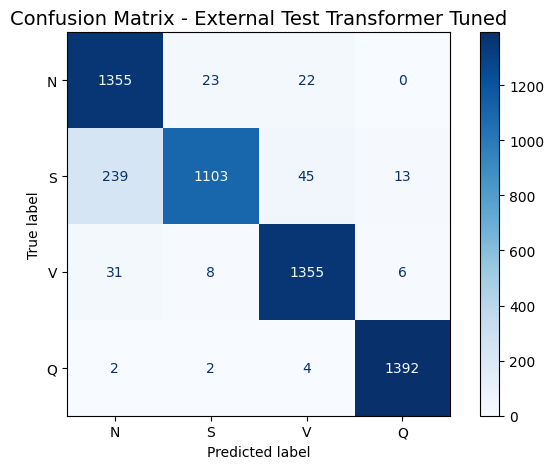

✅ Confusion matrix disimpan ke: transformer_tuned_external_outputs/confusion_matrix_external_transformer_tuned.png

=== 📈 RINGKASAN EVALUASI (EXTERNAL TEST SET) ===
🎯 Accuracy   : 0.929464
🎯 Precision  : 0.935129
🎯 Sensitivity: 0.929464
🎯 Specificity: 0.976488
🎯 F1-Score   : 0.928624
⚡ Avg Inference Time: 0.000031 s/sample

📁 CSV files saved:
   - transformer_tuned_external_outputs/external_summary_metrics_tuned.csv
   - transformer_tuned_external_outputs/external_per_class_metrics_tuned.csv

🔄 Calculating ROC-AUC...
📊 AUC Macro  : 0.988713
📊 AUC Micro  : 0.991755

💾 Model Information:
   - CPU Memory: 917.56 MB
   - GPU Memory: 35.22 MB
   - Model Size: 3.04 MB
   - Total Parameters: 796,164

🎉 EXTERNAL TEST EVALUATION COMPLETED!
📁 Results saved in: transformer_tuned_external_outputs
📊 Overall Accuracy: 0.9295
📊 F1-Score: 0.9286
📊 AUC Macro: 0.9887
📄 Detailed results saved to: transformer_tuned_external_outputs/detailed_results_tuned.txt


In [16]:
import os, time, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score)
import pandas as pd
from tqdm import tqdm

# ====== Config ======
BATCH_SIZE    = 64
NUM_CLASSES   = 4
CLASS_NAMES   = ['N', 'S', 'V', 'Q']
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

# Update path untuk model tuned (gunakan fold terbaik)
CKPT_PATH     = "checkpoints_transformer_tuned/transformer_tuned_fold1.pth"   # fold terbaik dari tuning
X_SIG_PATH    = "X_test_final.npy"  # Sinyal input test
Y_LABEL_PATH  = "y_test_final.npy"  # Label test

OUT_DIR       = "transformer_tuned_external_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
SAVE_CM_PNG   = os.path.join(OUT_DIR, "confusion_matrix_external_transformer_tuned.png")
SAVE_REPORT   = os.path.join(OUT_DIR, "classification_report_external_tuned.txt")
SAVE_SUMMARY  = os.path.join(OUT_DIR, "external_summary_metrics_tuned.csv")
SAVE_PERCLS   = os.path.join(OUT_DIR, "external_per_class_metrics_tuned.csv")

print(f"🚀 External Test - Transformer Tuned")
print(f"Using device: {DEVICE}")
print(f"Model checkpoint: {CKPT_PATH}")

# ====== Load External Test Set ======
X_signal = np.load(X_SIG_PATH)  # (N, L) atau (N, L, 1)
y_label = np.load(Y_LABEL_PATH)

print(f"📊 External test data loaded:")
print(f"Signal shape: {X_signal.shape}")
print(f"Labels shape: {y_label.shape}")
print(f"Class distribution: {np.bincount(y_label)}")

# Normalisasi (misal: skala ke [0,1] bila di luar range)
if X_signal.max() > 1.0 or X_signal.min() < 0.0:
    gmax, gmin = X_signal.max(), X_signal.min()
    if gmax != gmin:
        X_signal = (X_signal - gmin) / (gmax - gmin)
        print(f"🔧 Data normalized: [{gmin:.3f}, {gmax:.3f}] -> [0, 1]")

# Konversi ke tensor
X_signal_t = torch.tensor(X_signal, dtype=torch.float32)
y_label_t = torch.tensor(y_label, dtype=torch.long)

# Pastikan data sinyal memiliki dimensi [N, L, 1]
if X_signal_t.ndim == 2:
    X_signal_t = X_signal_t.unsqueeze(2)  # [N, L] -> [N, L, 1]

test_ds = TensorDataset(X_signal_t, y_label_t)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ====== Model: Transformer Encoder-Decoder (SAMA SEPERTI TRAINING) ======
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        # Memindahkan positional encoding ke perangkat yang sama dengan input x
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerEncoderDecoder(nn.Module):
    def __init__(self, input_dim=1, d_model=128, nhead=4, num_encoder_layers=3,
                 num_decoder_layers=2, dim_feedforward=256, dropout=0.1, num_classes=4, max_len=200):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)  # Proyeksi input sinyal
        self.pos_enc = PositionalEncoding(d_model, max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, 
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.bos_token = nn.Parameter(torch.randn(1, 1, d_model))  # Token untuk decoder
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        B, L, C = x.shape
        x = self.input_proj(x)  # [B, L, d_model]
        x = self.pos_enc(x)     # [B, L, d_model]

        memory = self.encoder(x)  # Output dari encoder [B, L, d_model]
        tgt = self.bos_token.expand(B, 1, -1)  # Target untuk decoder [B, 1, d_model]

        out = self.decoder(tgt=tgt, memory=memory)  # Output dari decoder [B, 1, d_model]
        out = out.squeeze(1)  # Mengubah menjadi [B, d_model]
        out = self.norm(out)  # Normalisasi
        logits = self.head(out)  # Output akhir [B, num_classes]
        return logits

# ====== Load checkpoint tuned model ======
print(f"🔧 Loading tuned model...")

# Gunakan konfigurasi optimal yang sama seperti training
model = TransformerEncoderDecoder(
    input_dim=1,
    d_model=128,           # Dari OPTIMAL_CONFIG
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    num_classes=NUM_CLASSES,
    max_len=200
).to(DEVICE)

if not os.path.exists(CKPT_PATH):
    raise FileNotFoundError(f"❌ Checkpoint tidak ditemukan: {CKPT_PATH}")

state = torch.load(CKPT_PATH, map_location=DEVICE)
if isinstance(state, dict) and 'state_dict' in state:
    state = state['state_dict']
state = {k.replace("module.", ""): v for k, v in state.items()}
model.load_state_dict(state, strict=True)
model.eval()

print(f"✅ Model loaded successfully!")

# ====== Evaluate ======
print(f"🔍 Starting evaluation on external test set...")
all_preds, all_labels, all_logits = [], [], []
inference_times = []

with torch.no_grad():
    for signal, labels in tqdm(test_loader, desc="Evaluasi External Test Set Transformer Tuned"):
        signal, labels = signal.to(DEVICE), labels.to(DEVICE)

        t0 = time.perf_counter()
        logits = model(signal)
        t1 = time.perf_counter()

        preds = torch.argmax(logits, dim=1)

        all_logits.append(logits.cpu())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        inference_times.append((t1 - t0) / signal.size(0))

# Menggabungkan hasil
all_logits = torch.cat(all_logits, dim=0)
y_probs = torch.softmax(all_logits, dim=1).numpy()
y_true  = np.array(all_labels)
y_pred  = np.array(all_preds)

# ====== Report & Confusion Matrix ======
report_txt = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=6)
print("\n" + "="*70)
print("=== 📊 EVALUASI EXTERNAL TEST SET - TRANSFORMER TUNED ===")
print("="*70)
print(report_txt)

with open(SAVE_REPORT, "w") as f:
    f.write("=== EVALUASI EXTERNAL TEST SET - TRANSFORMER TUNED ===\n")
    f.write("="*60 + "\n")
    f.write(report_txt)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=CLASS_NAMES, cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix - External Test Transformer Tuned", fontsize=14)
plt.tight_layout()
plt.savefig(SAVE_CM_PNG, dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Confusion matrix disimpan ke: {SAVE_CM_PNG}")

# ====== Ringkasan Metrics ======
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)
spec_per_cls = TN / (TN + FP + 1e-8)
spec_mean = spec_per_cls.mean()

avg_inference_time = float(np.mean(inference_times)) if inference_times else np.nan

print("\n" + "="*60)
print("=== 📈 RINGKASAN EVALUASI (EXTERNAL TEST SET) ===")
print("="*60)
print(f"🎯 Accuracy   : {acc:.6f}")
print(f"🎯 Precision  : {prec:.6f}")
print(f"🎯 Sensitivity: {rec:.6f}")
print(f"🎯 Specificity: {spec_mean:.6f}")
print(f"🎯 F1-Score   : {f1:.6f}")
print(f"⚡ Avg Inference Time: {avg_inference_time:.6f} s/sample")

# Simpan summary CSV
summary_df = pd.DataFrame([{
    "Model": "Transformer_Tuned",
    "Accuracy": acc, 
    "Precision": prec, 
    "Sensitivity": rec,
    "Specificity": float(spec_mean), 
    "F1-Score": f1,
    "AvgInference(s/sample)": avg_inference_time
}])
summary_df.to_csv(SAVE_SUMMARY, index=False)

# Per-class metrics dengan perhitungan yang benar
percls_metrics = []
for i, class_name in enumerate(CLASS_NAMES):
    # Binary classification untuk setiap kelas
    y_true_binary = (y_true == i).astype(int)
    y_pred_binary = (y_pred == i).astype(int)
    
    prec_cls = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    rec_cls = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1_cls = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    spec_cls = spec_per_cls[i]
    
    percls_metrics.append({
        "Class": class_name,
        "Precision": prec_cls,
        "Sensitivity": rec_cls,
        "Specificity": spec_cls,
        "F1-Score": f1_cls
    })

percls_df = pd.DataFrame(percls_metrics)
percls_df.to_csv(SAVE_PERCLS, index=False)

print(f"\n📁 CSV files saved:")
print(f"   - {SAVE_SUMMARY}")
print(f"   - {SAVE_PERCLS}")

# ====== ROC-AUC ======
print(f"\n🔄 Calculating ROC-AUC...")
try:
    y_true_1hot = np.eye(NUM_CLASSES)[y_true]
    auc_macro   = roc_auc_score(y_true_1hot, y_probs, average='macro', multi_class='ovr')
    auc_micro   = roc_auc_score(y_true_1hot, y_probs, average='micro', multi_class='ovr')
    print(f"📊 AUC Macro  : {auc_macro:.6f}")
    print(f"📊 AUC Micro  : {auc_micro:.6f}")
except Exception as e:
    print(f"❌ ROC AUC Calculation failed: {e}")
    auc_macro, auc_micro = np.nan, np.nan

# ====== Model Size & Memory Info ======
print(f"\n💾 Model Information:")
try:
    import psutil
    cpu_mem_mb = psutil.Process().memory_info().rss / 1024**2
    print(f"   - CPU Memory: {cpu_mem_mb:.2f} MB")
except Exception:
    cpu_mem_mb = float('nan')

try:
    if torch.cuda.is_available():
        gpu_mem_mb = torch.cuda.memory_allocated(DEVICE) / 1024**2
        print(f"   - GPU Memory: {gpu_mem_mb:.2f} MB")
    else:
        gpu_mem_mb = 0
except Exception:
    gpu_mem_mb = 0

param_size  = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
model_size_mb = (param_size + buffer_size) / 1024**2
total_params = sum(p.numel() for p in model.parameters())

print(f"   - Model Size: {model_size_mb:.2f} MB")
print(f"   - Total Parameters: {total_params:,}")

# ====== Final Summary ======
print("\n" + "="*70)
print("🎉 EXTERNAL TEST EVALUATION COMPLETED!")
print("="*70)
print(f"📁 Results saved in: {OUT_DIR}")
print(f"📊 Overall Accuracy: {acc:.4f}")
print(f"📊 F1-Score: {f1:.4f}")
if not np.isnan(auc_macro):
    print(f"📊 AUC Macro: {auc_macro:.4f}")
print("="*70)

# Save detailed results to text file
detailed_results = f"""
=== TRANSFORMER TUNED - EXTERNAL TEST RESULTS ===
Date: {time.strftime('%Y-%m-%d %H:%M:%S')}
Model: Transformer Encoder-Decoder (Tuned)
Checkpoint: {CKPT_PATH}

=== DATASET INFO ===
Test samples: {len(y_true)}
Classes: {CLASS_NAMES}
Class distribution: {dict(zip(CLASS_NAMES, np.bincount(y_true)))}

=== PERFORMANCE METRICS ===
Accuracy: {acc:.6f}
Precision: {prec:.6f}
Sensitivity/Recall: {rec:.6f}
Specificity: {spec_mean:.6f}
F1-Score: {f1:.6f}
AUC Macro: {auc_macro:.6f}
AUC Micro: {auc_micro:.6f}

=== COMPUTATIONAL METRICS ===
Average Inference Time: {avg_inference_time:.6f} s/sample
Model Size: {model_size_mb:.2f} MB
Total Parameters: {total_params:,}

=== PER-CLASS RESULTS ===
"""

for i, class_name in enumerate(CLASS_NAMES):
    detailed_results += f"\nClass {class_name}:\n"
    detailed_results += f"  Precision: {percls_metrics[i]['Precision']:.6f}\n"
    detailed_results += f"  Sensitivity: {percls_metrics[i]['Sensitivity']:.6f}\n"
    detailed_results += f"  Specificity: {percls_metrics[i]['Specificity']:.6f}\n"
    detailed_results += f"  F1-Score: {percls_metrics[i]['F1-Score']:.6f}\n"

with open(os.path.join(OUT_DIR, "detailed_results_tuned.txt"), "w") as f:
    f.write(detailed_results)

print(f"📄 Detailed results saved to: {os.path.join(OUT_DIR, 'detailed_results_tuned.txt')}")